# Compare OAE to DOR

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from itertools import product
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import box_model

Set ocean state

In [3]:
ocn_state = {
    'dic': 1958.72553055,
    'alk': 2261.89,
    'salt': 34.51,
    'temp': 24.37,
    'sio3': 4.23,
    'po4': 0.12,
}
ocn_state

{'dic': 1958.72553055,
 'alk': 2261.89,
 'salt': 34.51,
 'temp': 24.37,
 'sio3': 4.23,
 'po4': 0.12}

## Control integration

Integrate control run

In [4]:
%%time
# solve for equilibrium
csys_solver = box_model.calc_csys(**ocn_state)

forcing = dict(
    h=100.0, # m; mixed layer depth
    u10=7.5, # m/s; wind speed at 10 m
    Xco2atm=csys_solver.pco2, # µatm; atmospheric CO2
)

model = box_model.mixed_layer(**ocn_state, **forcing)
nday = 365 * 4
ds = model.run(nday)
ds

CPU times: user 9.14 s, sys: 153 ms, total: 9.29 s
Wall time: 9.68 s


<xarray.Dataset> Size: 47kB
Dimensions:  (time: 1460)
Coordinates:
  * time     (time) int64 12kB 0 1 2 3 4 5 6 ... 1454 1455 1456 1457 1458 1459
Data variables:
    dic      (time) float64 12kB 1.959e+03 1.959e+03 ... 1.959e+03 1.959e+03
    alk      (time) float64 12kB 2.262e+03 2.262e+03 ... 2.262e+03 2.262e+03
    pco2     (time) float64 12kB 357.1 357.1 357.1 357.1 ... 357.1 357.1 357.1

## OAE Experiment

Run an OAE experiment

In [5]:
%%time
oae_add = 10.0

# set up initial conditions for OAE experiment
ocn_state_oae = dict(**ocn_state)
ocn_state_oae['alk'] = ocn_state_oae['alk'] + oae_add

# init
model_oae = box_model.mixed_layer(**ocn_state_oae, **forcing)

ds_oae = model_oae.run(nday)
ds_oae

CPU times: user 7.64 s, sys: 121 ms, total: 7.76 s
Wall time: 8.02 s


<xarray.Dataset> Size: 47kB
Dimensions:  (time: 1460)
Coordinates:
  * time     (time) int64 12kB 0 1 2 3 4 5 6 ... 1454 1455 1456 1457 1458 1459
Data variables:
    dic      (time) float64 12kB 1.959e+03 1.959e+03 ... 1.967e+03 1.967e+03
    alk      (time) float64 12kB 2.272e+03 2.272e+03 ... 2.272e+03 2.272e+03
    pco2     (time) float64 12kB 343.6 343.8 344.1 344.3 ... 357.1 357.1 357.1

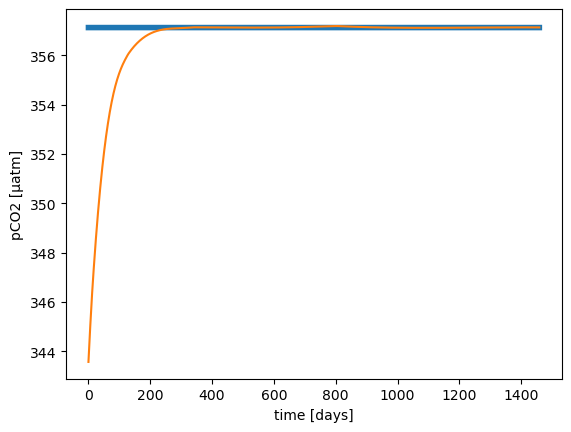

In [6]:
ds.pco2.plot(linewidth=4)
ds_oae.pco2.plot()

## DOR Experiment

In [7]:
%%time

# compute equivalent DIC removal
csys_solver = box_model.calc_csys(**ocn_state)
dor_rm = csys_solver.calc_new_dic_w_oae(ocn_state['alk'] + oae_add) - ocn_state['dic']

ocn_state_dor = dict(**ocn_state)
ocn_state_dor['dic'] = ocn_state_dor['dic'] - dor_rm

# init
model_dor = box_model.mixed_layer(**ocn_state_dor, **forcing)

# run
ds_dor = model_dor.run(nday)

CPU times: user 7.75 s, sys: 148 ms, total: 7.89 s
Wall time: 8.21 s


Comparisons

In [8]:
delta_dic_oae = (ds_oae.dic[-1] - ds.dic[-1]) * forcing['h']
delta_dic_dor = (ds_dor.dic[-1] - ds.dic[-1] + dor_rm) * forcing['h']

print(f"∆DIC (OAE) = {delta_dic_oae.values} mmol/m^2")
print(f"∆DIC (DOR) = {delta_dic_dor.values} mmol/m^2")

∆DIC (OAE) = 810.8244070260753 mmol/m^2
∆DIC (DOR) = 810.8305813779907 mmol/m^2


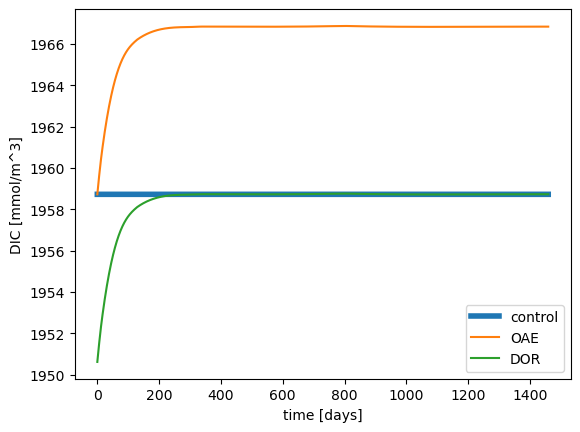

In [9]:
ds.dic.plot(linewidth=4, label='control')
ds_oae.dic.plot(label='OAE')
ds_dor.dic.plot(label='DOR')
plt.legend();

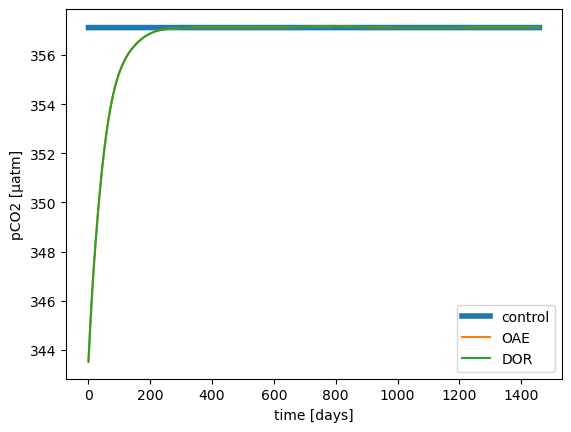

In [10]:
ds.pco2.plot(linewidth=4, label='control')
ds_oae.pco2.plot(label='OAE')
ds_dor.pco2.plot(label='DOR')
plt.legend();

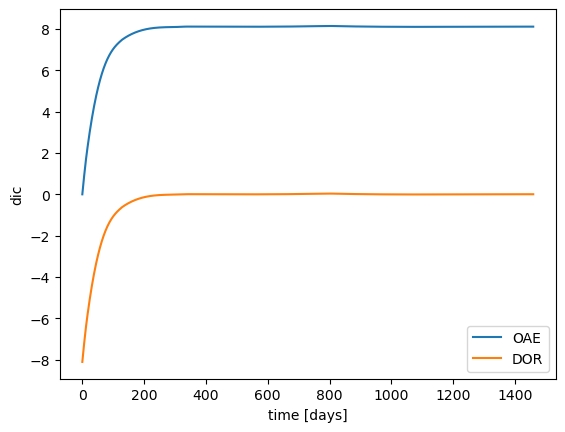

In [11]:
(ds_oae.dic - ds.dic).plot(label='OAE')
(ds_dor.dic - ds.dic).plot(label='DOR')
plt.legend();